In [1]:
import pickle
import random

import matplotlib.pyplot as plt
import numpy as np

In [2]:
with open("ocelot80k.pkl", "rb") as file:
    data = pickle.load(file)

data = [{"s": sample["s"],
         "current": sample["I"],
         "frequencies": sample["freq"],
         "formfactor": sample["formfactor"]} for sample in data]

In [3]:
s_max = np.abs(np.concatenate([sample["s"] for sample in data])).max()
s_max

0.0007591195528889543

In [8]:
samples = random.choices(data, k=3)

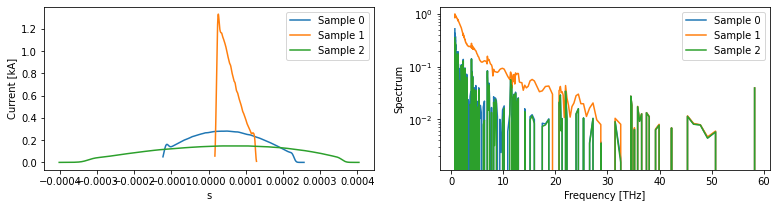

In [11]:
plt.figure(figsize=(13,3))

plt.subplot(121)
for i, sample in enumerate(samples):
    plt.plot(sample["s"], sample["current"]*1e-3, label=f"Sample {i}")
plt.xlabel("s")
plt.ylabel("Current [kA]")
plt.legend()
    
plt.subplot(122)
for i, sample in enumerate(samples):
    plt.plot(sample["frequencies"]*1e-12, sample["formfactor"], label=f"Sample {i}")
plt.yscale("log")
plt.xlabel("Frequency [THz]")
plt.ylabel("Spectrum")
plt.legend()

plt.show()

In [14]:
data[42]["current"][:10], data[0]["current"][:10]

(array([ 81.90026045,  90.33557014,  98.77087983, 107.33598259,
        116.29099706, 125.24601154, 134.18720913, 143.11048239,
        152.03375565, 160.57605653]),
 array([ 3.22122815,  3.93386291,  4.64649766,  5.45505228,  6.46649063,
         7.47792898,  8.70729482, 10.06972028, 11.43214574, 13.14466273]))

In [15]:
data[42]["frequencies"][:10], data[0]["frequencies"][:10]

(array([6.84283010e+11, 6.86342276e+11, 6.89291238e+11, 6.93231268e+11,
        6.97867818e+11, 7.03183896e+11, 7.09148197e+11, 7.15734438e+11,
        7.23107481e+11, 7.31240520e+11]),
 array([6.84283010e+11, 6.86342276e+11, 6.89291238e+11, 6.93231268e+11,
        6.97867818e+11, 7.03183896e+11, 7.09148197e+11, 7.15734438e+11,
        7.23107481e+11, 7.31240520e+11]))

In [3]:
ss = np.stack([sample["s"][:1000] for sample in data])
currents = np.stack([sample["I"][:1000] for sample in data])
frequencies = np.stack([sample["freq"][:240] for sample in data])
formfactors = np.stack([sample["formfactor"][:240] for sample in data])

In [4]:
ss.shape

(79200, 1000)

In [5]:
ss

array([[-2.70869501e-04, -2.70112254e-04, -2.69355008e-04, ...,
         4.84105144e-04,  4.84862390e-04,  4.85619637e-04],
       [-2.86069588e-04, -2.85275504e-04, -2.84481420e-04, ...,
         5.05631962e-04,  5.06426046e-04,  5.07220130e-04],
       [-3.01248100e-04, -3.00417151e-04, -2.99586202e-04, ...,
         5.27208000e-04,  5.28038949e-04,  5.28869898e-04],
       ...,
       [-4.84570924e-05, -4.82611410e-05, -4.80651896e-05, ...,
         1.46906450e-04,  1.47102401e-04,  1.47298353e-04],
       [-4.62062313e-05, -4.60134874e-05, -4.58207435e-05, ...,
         1.45959474e-04,  1.46152218e-04,  1.46344962e-04],
       [-4.39550971e-05, -4.37655360e-05, -4.35759749e-05, ...,
         1.45037280e-04,  1.45226841e-04,  1.45416402e-04]])